## Transfer Learning Tuning:
  * Use Resnet50 to reduce model size and improve accuracy 
      * see [base model info comparison](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
     
  * base_model: use RESNET50 and freeze at bottleneck layer (stop right before 2D AVERAGE POOL) 
  * top_model: tune dense layers (parameters are inspired by a few sources)
     * [source1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)
     * [source2](https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras)
     * [source3](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8)


  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0901 21:06:38.794243 140378810799936 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0901 21:06:38.795095 140378810799936 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
#### Import necessary libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras import optimizers
from keras.callbacks import ModelCheckpoint

---
#### Import train_df and test_df

In [3]:
train_df = pd.read_pickle('../pickle_files/train_df_glasses.pkl')
test_df = pd.read_pickle('../pickle_files/test_df_glasses.pkl')

#### Get bottleneck features to tune top models

In [13]:
def save_bottleneck_features(train_df, test_df, label, batch_size):
    '''
    inputs:
    train_df, test_df: train and test dataframes saved in pickle_files folder
    label: a string, eyewear, hat, or beard
    batch_size: process images in batches
    outputs:
    saves bottleneck features inside folder tuning_data as npy file
    '''
    # intialize the vgg16 model 
    # make sure not to train the top layers 
    base_model = ResNet50(weights = 'imagenet',include_top = False)
    # create train_generator and test_generator to get bottleneck inputs for train and test df 
    datagen = ImageDataGenerator(
        zoom_range= [0.8,1.7],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_input)
    # make sure shuffle is False so we know the label follows the sequence of the dataframe 
    # so we can tune top_model 
    train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(224,224),
    class_mode = None)
    # get features saved as .npy in tunign_data folder 
    bottleneck_features_train = base_model.predict_generator(
        train_generator, train_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/resnet_data/bottleneck_features_train_{label}_resnet50.npy','wb'),
           bottleneck_features_train)
    
    test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(224,224),
    class_mode = None)
    bottleneck_features_test = base_model.predict_generator(
        test_generator, test_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/resnet_data/bottleneck_features_test_{label}_resnet50.npy','wb'),
           bottleneck_features_test)

#### Save bottleneck_features

In [14]:
save_bottleneck_features(train_df,test_df,'eyewear',16)

Found 505 validated image filenames.
Found 127 validated image filenames.


### Quick tuning of top models 

In [23]:
def train_top_model(train_df, test_df, epoch, batch_size, label):
    '''
    inputs:
    train_df, test_df: dataframes saved in pickle_files to generate train and test labels 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    output:
    saves model weights in a folder 
    '''
    train_data = np.load(open(f'../tuning_data/resnet_data/bottleneck_features_train_{label}_resnet50.npy','rb'))
    # make sure train_data and train_label have same num of samples
    train_label = np.array(train_df[label].map({'not_'+label:0, label:1}))[:-(train_df.shape[0]%batch_size)]
    
    test_data = np.load(open(f'../tuning_data/resnet_data/bottleneck_features_test_{label}_resnet50.npy','rb'))
    test_label = np.array(test_df[label].map({'not_'+label:0, label:1}))[:-(test_df.shape[0]%batch_size)]
    
    # build top model
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer= optimizers.Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/resnet_data/best_bottleneck_resnet50_model_{label}.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.fit(train_data, train_label,
             epochs=epoch,
             batch_size=batch_size,
             validation_data=(test_data,test_label),
             callbacks=callbacks_list)
    del model
    keras.backend.clear_session()

#### run train_top_model and save results in tuning_data

In [24]:
train_top_model(train_df, test_df, 50, 16, 'eyewear')

Train on 496 samples, validate on 112 samples
Epoch 1/50
496/496 [==============================] - 3s 5ms/step - loss: 0.4655 - acc: 0.7923 - val_loss: 0.3515 - val_acc: 0.8750

Epoch 00001: val_acc improved from -inf to 0.87500, saving model to ../tuning_data/resnet_data/best_bottleneck_resnet50_model_eyewear.h5
Epoch 2/50
496/496 [==============================] - 0s 343us/step - loss: 0.1458 - acc: 0.9335 - val_loss: 0.5241 - val_acc: 0.8661

Epoch 00002: val_acc did not improve from 0.87500
Epoch 3/50
496/496 [==============================] - 0s 341us/step - loss: 0.1151 - acc: 0.9516 - val_loss: 0.3062 - val_acc: 0.9196

Epoch 00003: val_acc improved from 0.87500 to 0.91964, saving model to ../tuning_data/resnet_data/best_bottleneck_resnet50_model_eyewear.h5
Epoch 4/50
496/496 [==============================] - 0s 341us/step - loss: 0.0598 - acc: 0.9798 - val_loss: 0.2553 - val_acc: 0.9375

Epoch 00004: val_acc improved from 0.91964 to 0.93750, saving model to ../tuning_data/res

### Fine Tune Top Model to improve accuracy

In [21]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, print_model = True):
    # build VGG16 model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    model_resnet50 = ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))
    # build top model
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D(input_shape=model_resnet50.output_shape[1:]))
    top_model.add(Dense(512,activation='relu'))
    top_model.add(Dropout(0.25))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # load saved weights to fine tune parameters 
    top_model.load_weights(f'../tuning_data/resnet_data/best_bottleneck_resnet50_model_{label}.h5')
    # add top model to model
    model = Model(inputs=model_resnet50.input, outputs=top_model(model_resnet50.output))
    # we will tune last 5 layers of the model: activation49 and fully connected layer 
    for layer in model.layers[:-5]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum = 0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    train_gen = ImageDataGenerator(
        zoom_range= [0.8,1.7],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_input)
    # not want to augment the test 
    test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_generator =  train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode = 'binary')
    
    test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode = 'binary')
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/resnet_data/best_resnet50_model_{label}_decay_sdg_0.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # run and fit model 
    result = model.fit_generator(
    train_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//batch_size,
    verbose=1,
    callbacks=callbacks_list)
    
    if print_model:
        model.summary()
    
    del model
    keras.backend.clear_session()
    return result                

### save model history 

In [22]:
model_history = fine_tune_model(train_df, test_df,50,16,'eyewear', False)

Found 505 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Epoch 1/50
31/31 [==============================] - 6s 203ms/step - loss: 6.1580 - acc: 0.0963 - val_loss: 8.0185 - val_acc: 0.0804

Epoch 00001: val_acc improved from -inf to 0.08036, saving model to ../tuning_data/resnet_data/best_resnet50_model_eyewear_decay_sdg_0.h5
Epoch 2/50
31/31 [==============================] - 7s 213ms/step - loss: 3.7037 - acc: 0.1048 - val_loss: 4.6570 - val_acc: 0.1261

Epoch 00002: val_acc improved from 0.08036 to 0.12613, saving model to ../tuning_data/resnet_data/best_resnet50_model_eyewear_decay_sdg_0.h5
Epoch 3/50
31/31 [==============================] - 6s 194ms/step - loss: 2.2963 - acc: 0.1287 - val_loss: 2.8646 - val_acc: 0.0811

Epoch 00003: val_acc did not improve from 0.12613
Epoch 4/50
31/31 [==============================] - 6s 188ms/step - loss: 1.3822 - acc: 0.1866 - val_loss: 1.6555 - val_acc: 0.1712

Epoch 00004: val_ac

Epoch 39/50
31/31 [==============================] - 5s 177ms/step - loss: 0.1923 - acc: 0.9173 - val_loss: 0.3415 - val_acc: 0.8739

Epoch 00039: val_acc did not improve from 0.95495
Epoch 40/50
31/31 [==============================] - 5s 177ms/step - loss: 0.1681 - acc: 0.9315 - val_loss: 0.1737 - val_acc: 0.9189

Epoch 00040: val_acc did not improve from 0.95495
Epoch 41/50
31/31 [==============================] - 6s 188ms/step - loss: 0.2010 - acc: 0.9067 - val_loss: 0.2218 - val_acc: 0.9196

Epoch 00041: val_acc did not improve from 0.95495
Epoch 42/50
31/31 [==============================] - 6s 208ms/step - loss: 0.1864 - acc: 0.9395 - val_loss: 0.2842 - val_acc: 0.9099

Epoch 00042: val_acc did not improve from 0.95495
Epoch 43/50
31/31 [==============================] - 5s 176ms/step - loss: 0.2021 - acc: 0.9239 - val_loss: 0.2302 - val_acc: 0.8919

Epoch 00043: val_acc did not improve from 0.95495
Epoch 44/50
31/31 [==============================] - 6s 190ms/step - loss: 0.174

In [43]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')
# _1.h5 has 0.973 accuracy (better than 0.95 as _0.h5)
# consistent above 95% with 3 repeats of data generator 
# remove adam 

highest test accuracy: 0.9729729740469305
------------------
highest train accuracy: 0.9605809128630706


In [44]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.11295136594557548
------------------
lowest train loss: 0.12572764363025596


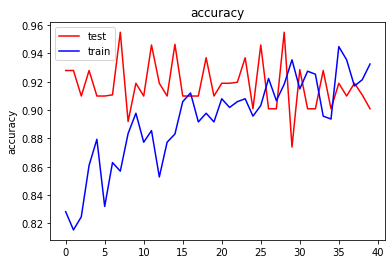

In [19]:
plt.plot(model_history.history['val_acc'][-40:], color = 'red', label = 'test')
plt.plot(model_history.history['acc'][-40:], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

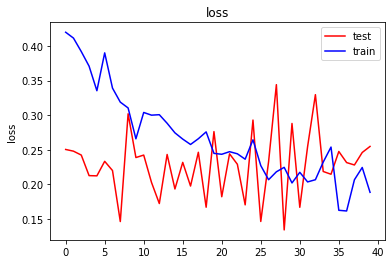

In [20]:
plt.plot(model_history.history['val_loss'][-40:], color = 'red', label = 'test')
plt.plot(model_history.history['loss'][-40:], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
model_history.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### Save model 

In [25]:
# save model artchitecture 
resnet50_model_5_up = model_history.model
resnet50_model_5_up_json = resnet50_model_5_up.to_json()

In [26]:
# serialize model to JSON
with open("../tuning_data/resnet_data/resnet50_model_5_up.json", "w") as json_file:
    json_file.write(resnet50_model_5_up_json)

In [29]:
# load json and create model
json_file = open('../tuning_data/resnet_data/resnet50_model_5_up.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [100]:
# load model weight yewear_decay_
loaded_model.load_weights('../tuning_data/resnet_data/best_resnet50_model_eyewear_1.h5')

In [101]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col='eyewear',
    batch_size=127,
    target_size=(224,224),
    class_mode = 'binary',
    shuffle = False)

Found 127 validated image filenames belonging to 2 classes.


In [102]:
loaded_model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])

In [103]:
loaded_model.evaluate_generator(test_generator)

[0.22826288640499115, 0.9212598204612732]

In [104]:
feature, label = next(test_generator)

In [105]:
# save the model
y_pred = np.around(loaded_model.predict_generator(test_generator, workers=8))

In [106]:
len(label)

127

In [107]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [108]:
fpr, tpr, thresholds = roc_curve(label, y_pred)
area = roc_auc_score(label, y_pred)

In [109]:
area

0.9217509920634921

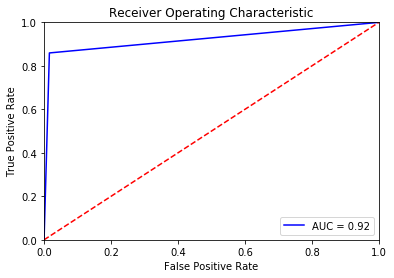

In [110]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [111]:
confusion_matrix(label, y_pred )

array([[62,  1],
       [ 9, 55]])

In [77]:
print(classification_report(label, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92        63
         1.0       0.96      0.86      0.91        64

    accuracy                           0.91       127
   macro avg       0.92      0.91      0.91       127
weighted avg       0.92      0.91      0.91       127



In [112]:
print(classification_report(label, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.93        63
         1.0       0.98      0.86      0.92        64

    accuracy                           0.92       127
   macro avg       0.93      0.92      0.92       127
weighted avg       0.93      0.92      0.92       127



W0901 22:01:58.699104 140378810799936 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


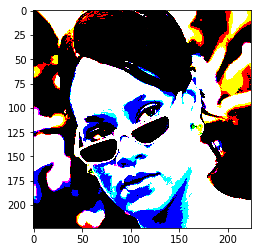

In [47]:
plt.imshow(feature[1])
plt.show()